In [1]:
# Google Colab, clone the repository for helper functions
%rm -rf * && rm -rf .*
!git clone https://github.com/Asheeshkrsharma/Identification-OpenCows.git .

rm: refusing to remove '.' or '..' directory: skipping '.'
rm: refusing to remove '.' or '..' directory: skipping '..'
Cloning into '.'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 479 (delta 109), reused 233 (delta 77), pack-reused 213
Receiving objects: 100% (479/479), 570.19 MiB | 29.85 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Checking out files: 100% (146/146), done.


In [21]:
# !pip3 install hiddenlayer
# !pip3 install tqdm

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
import hiddenlayer as hl
from tqdm import tqdm
from torch import optim
import numpy
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet

In [2]:
with tqdm(range(2), desc="Preparing dataset") as pbar:
  # Lambda function updates the tqdm progress bar.
  tqdmDescribe = lambda message, pbar: pbar.set_description(message); pbar.refresh()
  # The list of files is stored in the following files
  files = list(open("./utils/datasetLinks.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2020 ({len(files)} files from data.bris.ac.uk)", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  %rm -rf datasets && cat ./utils/datasetLinks.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  %mkdir -p datasets/OpenSetCows2020
  %mv -f ./datasets/*/identification ./datasets/OpenSetCows2020/ 2>/dev/null
  %rm -rf ./datasets/10m32xl88x2b61zlkkgz3fml17
  pbar.update()
!tree -C -d -L 3 -h ./datasets

Organizing dataset: 100%|██████████| 2/2 [00:34<00:00, 17.27s/it]

/bin/bash: tree: command not found


In [ ]:
# Opencows 2021
with tqdm(range(2), desc="Preparing dataset") as pbar:
  # Lambda function updates the tqdm progress bar.
  tqdmDescribe = lambda message, pbar: pbar.set_description(message);
  pbar.refresh()
  # The list of files is stored in the following files
  files = list(open("./utils/opencows2021.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2021 ({len(files)} files from data.bris.ac.uk)", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  %rm -rf datasets && cat ./utils/opencows2021.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  %mkdir -p datasets/OpenSetCows2021
  %mv -f ./datasets/*/Sub-levels ./datasets/OpenSetCows2021/ 2>/dev/null
  %rm -rf ./datasets/4vnrca7qw1642qlwxjadp87h7
  pbar.update()

Organizing dataset: 100%|██████████| 2/2 [07:42<00:00, 231.38s/it]


In [303]:
class Lstm(nn.Module):
    def __init__(self, inputSize, embeddingSize):
        super(Lstm, self).__init__()
        # self.Lstm = torch.nn.LSTM(input_size=inputSize,
        #                           hidden_size=embeddingSize,
        #                           num_layers=1, dropout=0.5, batch_first=True)
        self.Lstm = torch.nn.LSTM(
            input_size=inputSize,
            hidden_size=embeddingSize,
            num_layers=1,
            dropout=0.0,
            batch_first=True,
        )
        self.hidden_state = None

    def reset_hidden_state(self):
        self.hidden_state = None

    def forward(self, x):
        output, self.hidden_state = self.Lstm(x, self.hidden_state)
        return output, self.hidden_state


class LRResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        super(LRResNetMod, self).__init__()

        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=False)
        imagenetWeights = model_zoo.load_url(
            "https://data.bris.ac.uk/datasets/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Weights/Identification/current025_model_state.pkl"
        )

        # Just needed for the loading the model weights
        self.backbone.fc_embedding = nn.Linear(1000, embeddingSize)
        self.backbone.load_state_dict(imagenetWeights["model_state"])

        # We are now going to modify this layer
        for m in self.backbone.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        for child in self.backbone.children():
            for param in child.parameters():
                param.requires_grad = False
            for children_of_child in child.children():
                for param in children_of_child.parameters():
                    param.requires_grad = False

        self.relu = nn.ReLU(inplace=True)
        self.lstm = Lstm(2048, 1000)
        self.lstm2 = Lstm(1000, 512)
        self.dropout = nn.Dropout(0.6)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(512, 256)
        self.embedding = nn.Linear(256, embeddingSize)
        self.embeddingSize = embeddingSize
        self.softmax = nn.Sequential(nn.Linear(256, numClasses), nn.Softmax(dim=-1))

    def forwardOnce(self, x):
        # x has the following shape:
        # [
        #     Batch,
        #     sequence length (needs to be same for accross the batch,
        #     dynamic batching will be add later),
        #     channel,
        #     image height, image width
        # ]

        # Must be done before you run a new batch. Otherwise the LSTM will
        # treat a new batch as a continuation of a sequence
        self.lstm.reset_hidden_state()
        self.lstm2.reset_hidden_state()

        batch, timesteps, channels, h, w = x.shape
        x = x.view(batch * timesteps, channels, h, w)

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )

        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(self.backbone.layer1(x)))
            )
        )

        # Relu(FC)
        x = self.relu(x.view(x.size(0), -1))
        # Batch, number of images in each sequence, embddeing size
        x = x.view(batch, timesteps, -1)

        # Batch, number of images in each sequence, embddeing size
        x, _ = self.lstm(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        x_t = self.embedding(x)

        # Batch, numclasses
        x_f = x_t[:, -1, :]
        return x_t, x_f, self.softmax(self.relu2(x[:, -1, :]))

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        if (negative != None) & (positive != None):
            negativeEMBD, _, negativeSMax = self.forwardOnce(negative)
            anchorEMBD, _, anchorSMax = self.forwardOnce(anchor)
            positiveEMBD, _, positiveSMax = self.forwardOnce(positive)

            #_, negativeEMBD, negativeSMax = self.forwardOnce(negative)
            #_, anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            #_, positiveEMBD, positiveSMax = self.forwardOnce(positive)
            return (
                negativeEMBD,
                anchorEMBD,
                positiveEMBD,
                torch.cat((negativeSMax, anchorSMax, positiveSMax), 0),
            )
        else:
            em, anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            return em, anchorEMBD, anchorSMax


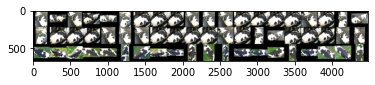

21 14
162


In [4]:
import matplotlib.pyplot as plt

trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=20,
    split='train',
    transform=False,
)

# Test
negative, anchor, positive, positiveLabel, negativeLabel = trainingDataset.__getitem__(1)
anc = [a.permute(1, 2, 0).numpy() for a in anchor]
pos = [a.permute(1, 2, 0).numpy() for a in positive]
neg = [a.permute(1, 2, 0).numpy() for a in negative]

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img if horizontal == 1 else img for img in images],
    axis=horizontal,
)

plt.imshow(compose([compose(anc, 1), compose(pos, 1), compose(neg, 1)], 0))
plt.show()
print(positiveLabel, negativeLabel)
print(len(trainingDataset))

In [304]:
import torch.nn.functional as F

def evaluate(model, dataLoader, device, lossFn):
    """Evaluates a loss on a dataset

    Parameters
    ----------
    model : Resnet model
        nn.Module
    dataLoader : testing/training dataset
        nn.DataLoader
    device : a GPU or a CPU
        str
    lossFn : Loss function
        nn.Module

    Returns
    -------
    Loss: Evaluated loss
        Number
    """
    model.eval()
    losses = []
    for step, (negatives, anchor, positives, positiveLabel, negativeLabel) in enumerate(
        dataLoader
    ):
        negatives, anchor, positives = (
            negatives.to(device),
            anchor.to(device),
            positives.to(device),
        )
        positiveLabel, negativeLabel = (
            positiveLabel.view(len(positiveLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device),
        )

        # The forward method returns three embeddings
        negativeEMBD, anchorEMBD, positiveEMBD, labels = model(
            anchor, negatives, positives
        )
        loss, rpl, interframe = lossFN(
            negativeEMBD, anchorEMBD,
            positiveEMBD, labels,
            torch.cat((positiveLabel, positiveLabel, negativeLabel), dim=0),
        )
        losses.append(loss.data)
        if step > 5:
          break
    return sum(losses) / len(losses)

class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, input=None, target=None):
        pred, labels = input, target
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()

# Reciprocal Triplet loss
class RTL(nn.Module):
    def __init__(self):
        super(RTL, self).__init__()

    def d(self, anchor, instance):
        return (anchor - instance).pow(2).sum(-1).sum(-1).sum()
        # return (anchor - instance).pow(2).sum(1).mean()

    def forward(self, negative, anchor, positive, prediction=None, target=None):
        # return self.d(anchor, positive) + (1 / self.d(anchor, negative)) + (1 / self.d(positive, negative))
        return self.d(anchor, positive) + (1 / self.d(anchor, negative))

class RTLSL(nn.Module):
    def __init__(self, _lambda=0.01):
        super(RTLSL, self).__init__()
        self._lambda = _lambda
        self.RTL = RTL()
        # self.CE = nn.CrossEntropyLoss(label_smoothing=0.5)
        self.device = device
        self.CE = nn.CrossEntropyLoss()
        # self.CE = NormalizedCrossEntropy(46)

    def hamm(self, total_data):
        hann_array = 0.5 - 0.5 * torch.cos((2 * torch.pi * torch.arange(0, total_data, 1)) / (total_data - 1))
        hann_array -= 1
        hann_array /= sum(hann_array)
        return hann_array

    def forwardOnce(self, negative, anchor, positive, prediction, target):
        rtlLoss = self.RTL(negative, anchor, positive)
        entropy = self.CE(input=prediction, target=target - 1)
        # return self._lambda * rtlLoss + entropy
        return self._lambda * rtlLoss + entropy

    def frameLevel(self, anchor, negative, positive):
        batchSize, seqLength, _ = anchor.shape
        window = self.hamm(seqLength).to(self.device)
        window = torch.linspace(1, 0, seqLength).to(device)

        a = torch.mul((anchor - torch.flip(anchor, [1])).pow(2).sum(2), window).sum(1).sum()
        b = torch.mul((negative - torch.flip(negative, [1])).pow(2).sum(2), window).sum(1).sum()
        c = torch.mul((positive - torch.flip(positive, [1])).pow(2).sum(2), window).sum(1).sum()

        return a + b + c

    def forward(self, negative, anchor, positive, prediction, target):
        interFrame = self.frameLevel(anchor, negative, positive)
        # print(interFrame)
        # totalLoss = 0
        # for i in range(10):
        #   idx = torch.randperm(negative.nelement())
        #   negative = negative.view(-1)[idx].view(negative.size())
        #   totalLoss += self.forwardOnce(negative, anchor, positive, prediction, target)
        # totalLoss /= 10.
        totalLoss = self.forwardOnce(negative[:, -1, :], anchor[:, -1, :], positive[:, -1, :], prediction, target)
        return  totalLoss + interFrame, totalLoss.item(), interFrame.item()

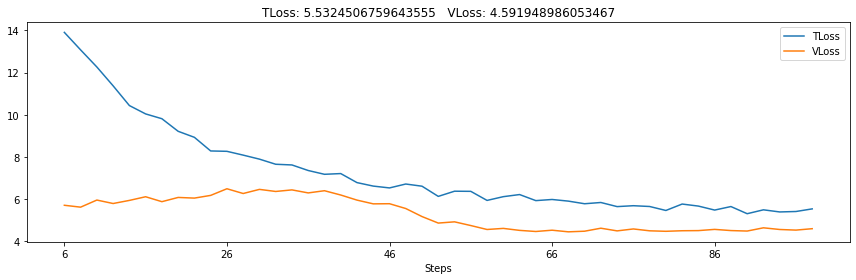

3.973896026611328, 1.3360755443572998: 100%|██████████| 100/100 [07:43<00:00,  4.63s/it]


In [305]:
trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=5,
    transform=False
)

testingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=5,
    transform=False,
    split="test"
)

# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# There are 155 individuals in the dataset
model = LRResNetMod(46)
model.to(device)

# Working parameter (71%)
trainingDataLoader = DataLoader(
    trainingDataset, batch_size=10, num_workers=1, shuffle=True
)

testingDataLoader = DataLoader(
    testingDataset, batch_size=10, num_workers=1, shuffle=True
)

optimiser = optim.SGD(model.parameters(), momentum=0.0, lr=1e-4, weight_decay=1e-4)

# We will use cross entropy loss for the training
lambdaFactor = 0.05
lossFN = RTLSL(lambdaFactor)

loss, numEpochs = 0, 100

# To store the training history
history, canvas = hl.History(), hl.Canvas()

with tqdm(range(numEpochs), desc="Training epochs", position=0) as pbar:
    pbar.refresh()
    # Start training
    model.train()
    for epoch in range(numEpochs):
        # Prepare a batch of 5 sequences with 10 images each
        # with three channels and (224, 224) size
        negatives, anchor, positives, positiveLabel, negativeLabel = next(
            iter(trainingDataLoader)
        )
        negatives, anchor, positives = (
            negatives.to(device),
            anchor.to(device),
            positives.to(device),
        )
        positiveLabel, negativeLabel = (
            positiveLabel.view(len(positiveLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device),
        )
        # Calculate loss and Back propagate
        def backPropagate():
            optimiser.zero_grad()
            negativeEMBD, anchorEMBD, positiveEMBD, labels = model(
                anchor, negatives, positives
            )
            # print(lossFN.frameLevel(anchorEMBD, negativeEMBD, positiveEMBD))
            loss, rpl, interframe = lossFN(
                negativeEMBD, anchorEMBD,
                positiveEMBD, labels,
                torch.cat((positiveLabel, positiveLabel, negativeLabel), dim=0),
            )
            loss.backward()
            return loss, rpl, interframe

        loss, rpl, interframe = optimiser.step(backPropagate)
        # Every second iteration, calculate model accuracy, evaluate the loss
        # function on the test dataset. Save the experiment history
        if epoch % 2 == 0 and epoch > 5:
            Vloss = evaluate(model, testingDataLoader, device, RTLSL(lambdaFactor))
            history.log(epoch, TLoss=loss.data, VLoss=Vloss)
            model.train()
            with canvas:
                canvas.draw_plot([history["TLoss"], history["VLoss"]])
        pbar.set_description("{}, {}".format(rpl, interframe))
        pbar.update()
    pbar.refresh()


In [338]:
# Core libraries
import numpy as np
from itertools import combinations

# PyTorch
import torch

"""
File contains a selection of mining utilities for selecting triplets
Code is adapted from - https://github.com/adambielski/siamese-triplet
"""

# Find the distance between two vectors
def pdist(vectors):
    print(vectors.shape)
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

# Should return indices of selected anchors, positive and negative samples
# e.g. np array of shape [N_triplets x 3]
class TripletSelector:
    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

# Return all possible triplets
class AllTripletSelector(TripletSelector):
    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None

def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None

def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

# For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
# Margin should match the margin used in triplet loss.
# negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
# and return a negative index for that pair
class FunctionNegativeTripletSelector(TripletSelector):
    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for i in range(labels.shape[0]):
            label = labels[i,0]
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                if loss_values.size != 0:
                    hard_negative = self.negative_selection_fn(loss_values)
                    if hard_negative is not None:
                        hard_negative = negative_indices[hard_negative]
                        triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        return torch.LongTensor(np.array(triplets)), len(triplets)

def HardestNegativeTripletSelector(margin=0, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=hardest_negative,
                                                                                 cpu=cpu)


def RandomNegativeTripletSelector(margin=0, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                negative_selection_fn=random_hard_negative,
                                                                                cpu=cpu)


def SemihardNegativeTripletSelector(margin=0, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                  negative_selection_fn=lambda x: semihard_negative(x, margin),
                                                                                  cpu=cpu)

In [341]:
selector = HardestNegativeTripletSelector()

negatives, anchor, positives, positiveLabel, negativeLabel = next(
    iter(trainingDataLoader)
)
negatives, anchor, positives = (
    negatives.to(device),
    anchor.to(device),
    positives.to(device),
)
positiveLabel, negativeLabel = (
    positiveLabel.view(len(positiveLabel)).to(device),
    negativeLabel.view(len(negativeLabel)).to(device),
)

negativeEMBD, anchorEMBD, positiveEMBD, labels = model(
    anchor, negatives, positives
)

batchsize, seqlength, _ = anchorEMBD.shape
# Combine the embeddings from each network
embeddings = torch.cat((anchorEMBD, positiveEMBD, negativeEMBD), dim=0)
embeddings = embeddings.view((batchsize * 3 * seqlength, -1))

# Concatenate labels for softmax/crossentropy targets
target = torch.cat((torch.repeat_interleave(positiveLabel, seqlength),
           torch.repeat_interleave(positiveLabel, seqlength),
           torch.repeat_interleave(negativeLabel, seqlength)),dim=0)

# 		# Get the (e.g. hardest) triplets in this minibatch
# 		triplets, num_triplets = self.triplet_selector.get_triplets(embeddings, labels)

In [344]:
# selector.get_triplets(embeddings, target)
labels.shape

torch.Size([30, 46])

In [308]:
modelPrefix = 'LRCNN'
torch.save(model.state_dict(), f"./models/{modelPrefix}.pth")

In [309]:
def infer(dataset, model):
    embeddings, labels  = numpy.zeros((1, 128)), numpy.zeros((1))
    embeddingsAll, labelsAll  = numpy.zeros((1, 128)), numpy.zeros((1))
    indeces = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(dataset.__len__()), desc="Inferencing tracklets"):
        tracklet, label = dataset.__getitem__(i)

        tracklet = tracklet.to(device)
        all, embd, pred = model(tracklet[None, :])

        all = all.data.cpu().numpy()
        indeces.append((len(embeddingsAll) - 1, (len(embeddingsAll) - 1) + len(all[0])-1))

        embeddingsAll = numpy.concatenate((embeddingsAll, all[0]), axis=0)
        labelsAll = numpy.concatenate((labelsAll, numpy.ones(tracklet.shape[0]) * label))
        embeddings = numpy.concatenate((embeddings, embd.data.cpu().numpy()), axis=0)
        labels = numpy.concatenate((labels, numpy.array([label])), axis=0)

    embeddings, labels = embeddings[1:], labels[1:]
    embeddingsAll, labelsAll = embeddingsAll[1:], labelsAll[1:]
    return embeddingsAll, labelsAll, embeddings, labels, indeces

# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LRResNetMod(46)
model.load_state_dict(torch.load(f"./models/{modelPrefix}.pth"))
model.to(device)

trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    transform=False,
    split='train'
)

testingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "utils/opencowsTracklets2020V2.json",
    maxSequenceLength=None,
    transform=False,
    split='test'
)

print('Get test embeddings')
testEmbeddingsAll, testLabelsAll, testEmbeddings, testLabels, testIdeces = infer(testingDataset, model)

print('Get train embeddings')
trainEmbeddingsAll, trainLabelsAll, trainEmbeddings, trainLabels, trainIdeces = infer(trainingDataset, model)

Get test embeddings


Inferencing tracklets: 100%|██████████| 77/77 [00:02<00:00, 27.59it/s]


Get train embeddings


Inferencing tracklets: 100%|██████████| 162/162 [01:25<00:00,  1.90it/s]


In [311]:
# Model accuracy
accuracy = lambda p, l:  numpy.mean(p.astype(int).ravel() == l.astype(int).ravel()) * 100

KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-4)
KNN.fit(trainEmbeddingsAll, trainLabelsAll - 1)

# We compare just the last output for the evaluating the model accuracy
print("KNN accuracy: {}%".format(accuracy(KNN.predict(trainEmbeddings), trainLabels - 1)))
print("KNN accuracy: {}%".format(accuracy(KNN.predict(testEmbeddings), testLabels - 1)))

KNN accuracy: 100.0%
KNN accuracy: 29.87012987012987%


In [11]:
# !pip3 install umap-learn
# import umap
# fit = umap.UMAP(n_neighbors=5)
# reduction = fit.fit_transform(trainEmbeddingsAll, y=trainLabelsAll - 1)


In [12]:
# import matplotlib.pyplot as plt
# plt.scatter(reduction[:, 0], reduction[:, 1])

In [261]:
# perplexity mentioned in the paper is 30, rest arguments are mentioned as useful defaults
tSNE = TSNE(n_components=2, learning_rate='auto', perplexity=8, init='pca')
reduction = tSNE.fit_transform(trainEmbeddingsAll)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


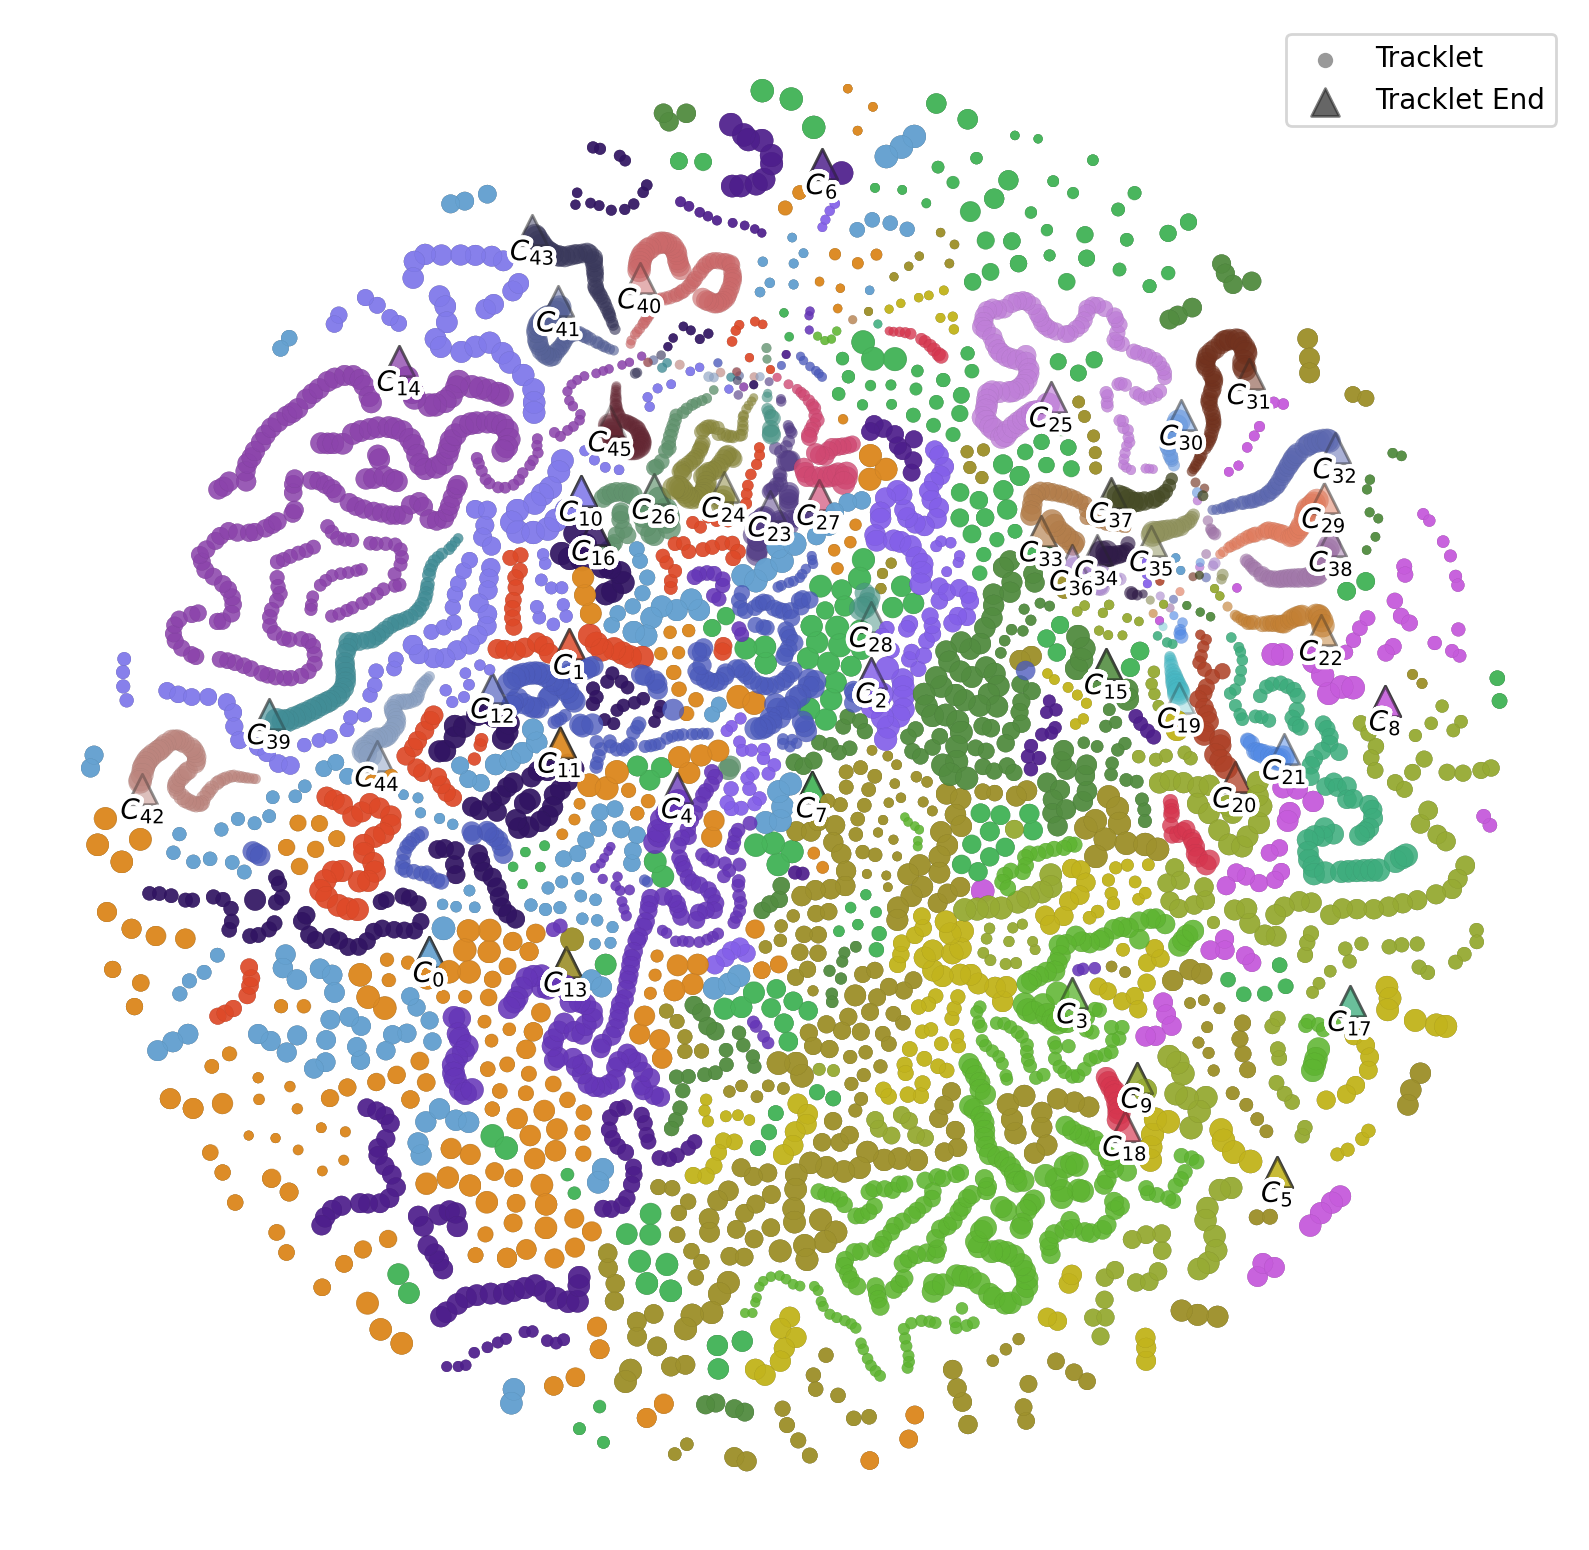

In [263]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patheffects as PathEffects


colors = numpy.asarray(
    [
        [102, 162, 209], [222, 74, 41], [132, 96, 233], [94, 181, 49],
        [102, 54, 184], [194, 180, 29], [78, 31, 140], [72, 182, 92],
        [198, 92, 220], [151, 171, 52], [130, 123, 235], [221, 139, 36],
        [76, 91, 188], [159, 146, 46], [140, 68, 172], [83, 141, 65],
        [50, 21, 99], [61, 173, 125], [214, 54, 79], [70, 183, 195],
        [175, 66, 40], [83, 138, 229], [195, 128, 52], [84, 62, 134],
        [137, 135, 60], [191, 127, 216], [97, 147, 110], [208, 72, 114],
        [73, 148, 134], [224, 124, 94], [107, 154, 223], [114, 50, 30],
        [92, 104, 176], [179, 126, 75], [48, 28, 72], [144, 146, 93],
        [173, 140, 208], [71, 76, 39], [162, 120, 170], [65, 141, 150],
        [203, 105, 106], [86, 98, 151], [188, 133, 126], [59, 58, 93],
        [137, 159, 193], [101, 40, 52], [72, 99, 130],
    ]
)
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=200)

reductionTracklets = [reduction[range[0] : range[1]] for range in trainIdeces]
labelTracklets = [list(set(trainLabelsAll[range[0] : range[1]] - 1))[0] for range in trainIdeces]
faceColors = [colors[int(label)] / 255.0 for label in labelTracklets]
labelSize = [list(numpy.linspace(10, 70, num=(r[1] - r[0])-2)) for r in trainIdeces]
faceAlpha = [list(numpy.linspace(0.1, 0.6, num=(r[1] - r[0])-2)) for r in trainIdeces]

for i in range(len(reductionTracklets)):
    r = reductionTracklets[i]
    plt.scatter(
        r[:, 0][0:-2], r[:, 1][0:-2],
        s=labelSize[i], alpha=0.4,
        edgecolor="#262626",
        linewidth=0.02,
        color=faceColors[i],
    )
    plt.scatter(
        r[:, 0][-1], r[:, 1][-1],
        s=120, alpha=0.3,
        edgecolor="#262626",
        marker="^",
        linewidth=1,
        color=faceColors[i],
    )
    text = ax.text(r[:, 0][-1], r[:, 1][-1]-6, f"$C_{{{int(labelTracklets[i])}}}$",
        fontsize=10,
        horizontalalignment="center",
        verticalalignment="center",
    )
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

plt.scatter(
    [], [],
    s=30, alpha=0.4,
    edgecolor="#262626",
    linewidth=0.02,
    color='black',
    label='Tracklet'
)
plt.scatter(
    [], [],
    s=100, alpha=0.6,
    edgecolor="#262626",
    marker="^",
    linewidth=1,
    color='black',
    label='Tracklet End'
)

# Viz tweaks https://olgabotvinnik.com/blog/prettyplotlib-painlessly-create-beautiful-matplotlib
[ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.axis("tight")
ax.legend()
plt.show()

In [ ]:
from torch._C import Stream
# TODOs
# Increase the lr 5r-2 yeilds 84% Highest ever been
# Strategy:
# Increase the loss weights (RTL), if loss looks bland (does not decrease), increase the lr, if still doesnt? increase number of layers.
# In the order as as said!